In [52]:
import pandas as pd
import os 
import numpy as np 
import matplotlib.pyplot as plt
from modules import utils as ut
from modules import data_processing as dp
from modules import data_retrieval as dr 

In [2]:
%matplotlib inline

In [37]:
def get_data(station,dom):
    total_oa = pd.read_csv(f'/home/hnavarro/Desktop/PHD_BSC/GIT/organic_aerosols/M_DATA/a431/2018/{dom}/Data_{station}_{dom}.csv',
                            index_col = 0, parse_dates = True)
    total_oa = total_oa.resample('D').mean()
    total_oa = total_oa[['pm2p5poa','pm2p5soa']]

    no_gfas = pd.read_csv(f'/home/hnavarro/Desktop/PHD_BSC/GIT/organic_aerosols/M_DATA/a5gtpa5gx/2018/{dom}/Data_{station}_{dom}.csv',
                            index_col = 0, parse_dates = True)
    no_gfas = no_gfas.resample('D').mean()
    no_gfas = no_gfas[['pm2p5poa','pm2p5soa']]

    no_shipping = pd.read_csv(f'/home/hnavarro/Desktop/PHD_BSC/GIT/organic_aerosols/M_DATA/a5hapa5hb/2018/{dom}/Data_{station}_{dom}.csv',
                            index_col = 0, parse_dates = True)
    no_shipping = no_shipping.resample('D').mean()
    no_shipping = no_shipping[['pm2p5poa','pm2p5soa']]

    no_residential = pd.read_csv(f'/home/hnavarro/Desktop/PHD_BSC/GIT/organic_aerosols/M_DATA/a4di/2018/{dom}/Data_{station}_{dom}.csv',
                            index_col = 0, parse_dates = True)
    no_residential = no_residential.resample('D').mean()
    no_residential = no_residential[['pm2p5poa','pm2p5soa']]

    no_traffic = pd.read_csv(f'/home/hnavarro/Desktop/PHD_BSC/GIT/organic_aerosols/M_DATA/a4dj/2018/{dom}/Data_{station}_{dom}.csv',
                            index_col = 0, parse_dates = True)  
    no_traffic = no_traffic.resample('D').mean()
    no_traffic = no_traffic[['pm2p5poa','pm2p5soa']]

    return total_oa, no_gfas, no_shipping, no_residential, no_traffic

In [39]:
def get_contribution(station, dom):
    tot, no_gfas, no_shipping, no_residential, no_traffic = get_data(station,dom)

    gfas = tot - no_gfas
    shipping = tot - no_shipping
    residential = tot - no_residential
    traffic = tot - no_traffic
    others = tot - (gfas + shipping + residential + traffic)
    #remove negative values
    gfas[gfas < 0] = 0
    shipping[shipping < 0] = 0
    residential[residential < 0] = 0
    traffic[traffic < 0] = 0
    others[others < 0] = 0
    return gfas, shipping, residential, traffic, others

In [88]:
def plot_mass_contributions(station, dom):
    data_obs = dr.get_mass_obs(ut.convention_names_stations()["acr_first"][station], remove_negatives=True)

    gfas, shipping, residential, traffic, others = get_contribution(station,dom)
    gfas['oagfs'] = gfas['pm2p5poa'] + gfas['pm2p5soa']
    shipping['oashp'] = shipping['pm2p5poa'] + shipping['pm2p5soa']
    residential['oares'] = residential['pm2p5poa'] + residential['pm2p5soa']
    traffic['oatrf'] = traffic['pm2p5poa'] + traffic['pm2p5soa']
    others['oaoth'] = others['pm2p5poa'] + others['pm2p5soa']
    #eliminar columnas pm2p5poa y pm2p5soa de cada dataframe
    gfas = gfas.drop(columns = ['pm2p5poa','pm2p5soa'])
    shipping = shipping.drop(columns = ['pm2p5poa','pm2p5soa'])
    residential = residential.drop(columns = ['pm2p5poa','pm2p5soa'])
    traffic = traffic.drop(columns = ['pm2p5poa','pm2p5soa'])
    others = others.drop(columns = ['pm2p5poa','pm2p5soa'])
    
    #concatenate all dataframes en un solo dataframe
    df = pd.concat([gfas, shipping, residential, traffic, others], axis = 1)
    #ordenar columnas
    orden_categorias = ['oashp', 'oagfs', 'oares', 'oatrf', 'oaoth']
    df = df[orden_categorias]

     # Definir colores y etiquetas personalizadas
    colores = {
        'oares': '#1f77b4',  # Azul claro
        'oagfs': '#ff7f0e',  # Naranja
        'oatrf': '#000000',  # Negro mate
        'oashp': '#2ca02c',
        'oaoth': '#8c564b'
    }
    
    etiquetas_personalizadas = {
        'oagfs': 'GFAS',
        'oares': 'RES',
        'oatrf': 'TRF',
        'oashp': 'SHP',
        'oaoth': 'OTH'
    }
    
    # Crear el gráfico de áreas
    ax = df.plot.area(stacked=True, alpha=0.5, color=[colores.get(col, 'gray') for col in df.columns], figsize=(12, 6))

    # Añadir puntos de observación
    color_obs = 'red'
    ax.plot(data_obs, color=color_obs, marker='o', linestyle='--', ms=3, lw=0.8, alpha=0.6)
    
    # Añadir títulos y etiquetas
    plt.title(station, fontsize=16, fontweight='bold')
    plt.xlabel('months', fontsize=14)
    plt.ylabel(r'OA ($\mu g/m^3$)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Añadir rejilla
    plt.grid(True, linestyle='--', alpha=0.5)
    
    #set limite del eje y como el maximo entre mod y obs 
    max_val = max(df.max(axis=1).max(), data_obs.max(axis=1).max())
    plt.ylim(0, max_val + 0.5)
    # Crear una lista de etiquetas con colores personalizados
    etiquetas_con_colores = [
        (etiquetas_personalizadas.get(col, col), colores.get(col, None))
        for col in df.columns
    ]
    
    # Añadir leyenda con etiquetas personalizadas y colores
    handles = [plt.Line2D([0], [0], color=color, lw=4) for etiqueta, color in etiquetas_con_colores]
    labels = [etiqueta for etiqueta, _ in etiquetas_con_colores]

    # Añadir leyenda de observaciones
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_obs, markersize=10))
    labels.append('OBS')
    
    plt.legend(handles=handles, labels=labels, loc='upper center', fontsize='small', title='Contribution', title_fontsize='13', ncol=6)
    
    # Ajustar el espacio en el eje Y
    #set limite del eje y como el maximo entre mod y obs 
    max_df = df.sum(axis=1).values.max()
    max_data_obs = data_obs.max().values[0]

    # Obtener el máximo entre max_df y max_data_obs
    max_val = max(max_df, max_data_obs)
    plt.ylim(-0.1, max_val+0.1)

    os.makedirs("figures_paper", exist_ok=True)
    plt.savefig(f'figures_paper/contribution_{station}_{dom}.png', dpi=300, bbox_inches='tight')

    return plt.show()

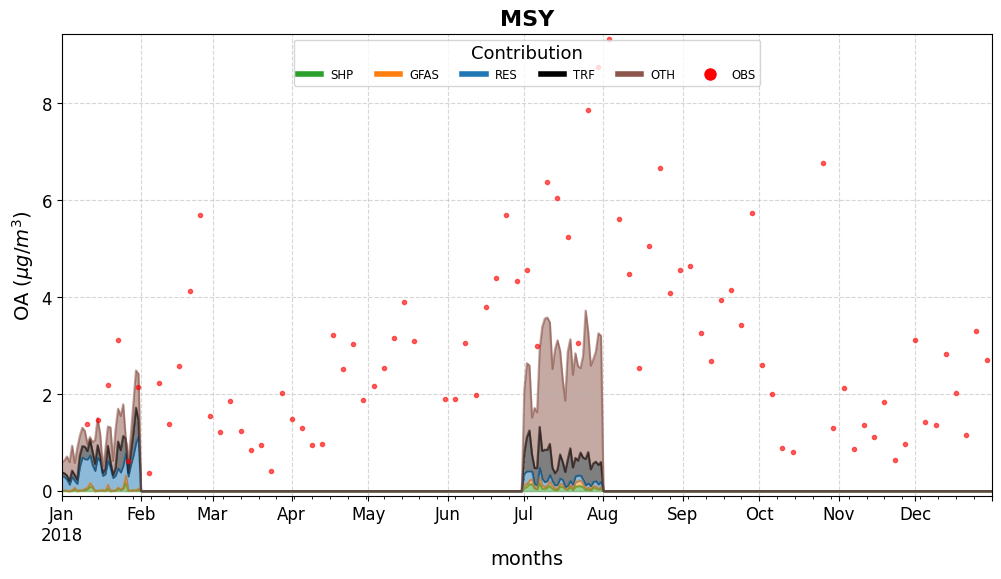

In [90]:
plot_mass_contributions('MSY','d02')